In [279]:
include("Birkhoff_Functions/src/Birkhoff_Functions.jl")
using .Birkhoff_Functions

using QuadGK
using Base.Threads
using JLD

In [280]:
### Incremental Convergence - after finding quasi orbit for say 2000 evols, if want 4000 evols, don't need to recompute for it
# i.e. after testing convergence, find the i which are quasi and can delete those rows from the delta summation vectors 
# and the right_delta_evolutions and the WB_2N extension ones and reduce global num_initial_conditions.
### Preallocated space scatterdump, ### Parallelism, ### INF ORBITS

### Defining Variables and Functions

In [313]:
const r = 1.4
const N_zeros = 18

num_initial_conditions = 1000
delta_0 = 500

function h_obs(x)
    return sin(x[1]+x[2])
end

function f(x)
    return exp(-abs(1/x))
end

function k(x)
    return exp(-abs(1/x))
end

function q(x)
    return abs(x)
end

function continuable_weighted_birkhoff_function(x_n, N, delta_n)

    if (delta_n-1 <= x_n && x_n < (N-1)-(delta_n-1))
        return 1
    end

    function g(x_n) return f(x_n)/(f(x_n)+k(1-x_n)) end
    function h(x_n) return 1-g(q(x_n)/q(delta_n-1)) end

    if (x_n < delta_n-1)
        return h(x_n-(delta_n-1))
    else
        return h(x_n-(N-delta_n))
    end
end;

### Calculate Area of Base Case

In [314]:
fixed_param_f(x) = continuable_weighted_birkhoff_function(x, 2*delta_0-1, delta_0)

delta_A_0 = Birkhoff_Functions.initial_area_delta(delta_0, fixed_param_f)

249.49999999999164

### Generate Initial Conditions ###

In [315]:
original_initial_conditions = Birkhoff_Functions.generate_ICs(num_initial_conditions, BigFloat);

### Calculates the Birkhoff Computation for the Deltas

In [316]:
function WB_delta(WB_delta, start, finish, evolutions, curr_N, delta)
    for i in 1:length(evolutions)
        temp = zeros(BigFloat, Threads.nthreads())
        Threads.@threads for j in start-1:finish-1
            # println("Right Tuple ", evolutions[i][j-start+2+length(evolutions[1])-delta], " h() ", h(evolutions[i][j-start+2+length(evolutions[1])-delta]), " j ", j, " bump_y ", continuable_weighted_birkhoff_function(j, curr_N, delta), " total ", continuable_weighted_birkhoff_function(j, curr_N, delta) * h(evolutions[i][j-start+2+length(evolutions[1])-delta]))
            temp[Threads.threadid()] += continuable_weighted_birkhoff_function(j, curr_N, delta) * h_obs(evolutions[i][j-start+2+length(evolutions[1])-delta])
        end
        WB_delta[i] = sum(temp)
    end
end;

### Create Initial Base Case

In [317]:
function base_case(original_initial_conditions, delta)

    # Set the variables.
    evolutions = deepcopy(original_initial_conditions)
    scatter_dump = Tuple{Float64, Float64}[]
    WB_left = zeros(BigFloat, length(original_initial_conditions))
    WB_middle = zeros(BigFloat, length(original_initial_conditions))
    WB_right = zeros(BigFloat, length(original_initial_conditions))

    # Add the initial conditions to the scatter dump.
    # for initial_condition in original_initial_conditions
    #     append!(scatter_dump, initial_condition)            
    # end

    curr_N = 2*delta-1

    # Evolve to form the base case evolutions.
    extended_evolutions, _, curr_N = Birkhoff_Functions.evolve_system_to_N(length(evolutions), [r,1], evolutions, scatter_dump, 1, curr_N-1)

    # println("Base Case Evolutions: ", evolutions)

    # Calculates the Birkhoff sum for the left delta.
    for i in 1:length(extended_evolutions)
        temp = zeros(BigFloat, Threads.nthreads())
        Threads.@threads for j in 0:delta-2
            # println("Left Tuple ", evolutions[i][j+1], " h() ", h(evolutions[i][j+1]), " j ", j, " bump_y ", continuable_weighted_birkhoff_function(j, curr_N, delta), " total ", continuable_weighted_birkhoff_function(j, curr_N, delta) * h(extended_evolutions[i][j+1]))
            temp[Threads.threadid()] += continuable_weighted_birkhoff_function(j, curr_N, delta) * h_obs(extended_evolutions[i][j+1])
        end
        WB_left[i] = WB_left[i] .+ sum(temp)
    end

    WB_delta(WB_right, curr_N-delta+1, curr_N, extended_evolutions, curr_N, delta)

    # Store the right delta of evolutions.
    right_delta_evolutions = [subvector[setdiff(1:end, 1:(length(extended_evolutions[1])-delta))] for subvector in extended_evolutions]

    return right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N
end;

### Evolves the System to a new N

In [318]:
function evolve_to_N(wanted_N, right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N, delta)
    extended_evolutions, scatter_dump, curr_N = Birkhoff_Functions.evolve_system_to_N(length(right_delta_evolutions), [r,1], right_delta_evolutions, scatter_dump, curr_N, wanted_N - curr_N)

    # println("Continued Evolutions: ", right_delta_evolutions)

    # Add the sum of the middle, between inclusive left and strictly right delta
    for i in 1:length(right_delta_evolutions)
        temp = zeros(BigFloat, Threads.nthreads())
        Threads.@threads for j in 1:length(extended_evolutions[1])-delta
            # println("Added middle ", right_delta_evolutions[i][j], " ", h(right_delta_evolutions[i][j]))
            temp[Threads.threadid()] += h_obs(extended_evolutions[i][j])
        end

        WB_middle[i] = WB_middle[i] .+ sum(temp)
    end

    # Recalculate the WB of the right delta.
    WB_delta(WB_right, curr_N-delta+1, curr_N, extended_evolutions, curr_N,delta)

    # Store the right delta of evolutions.
    right_delta_evolutions = [subvector[setdiff(1:end, 1:(length(extended_evolutions[1])-delta))] for subvector in extended_evolutions]

    return right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N
end;

#### Base Case

In [319]:
right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N = base_case(original_initial_conditions, delta_0);
# println("Delta ", delta_0)
# println("Right Delta Evolutions ", right_delta_evolutions)
# println("WB_left ", WB_left)
# println("WB_middle ", WB_middle)
# println("WB_right ", WB_right)
# println("curr_N ", curr_N)


(Vector{Tuple{BigFloat, BigFloat}}[[(5.507898896110320050093977933814445005479227200210364277125117920633264280498108, 0.8357183223468245153462841574542238156084279440410641626660232556049468683330583), (0.06043191127755808851497532470966305269331634550121679784125199162257833625879628, 0.9202715112676397890649647548522625017378560445154597051253026553084600863775901), (0.9807034225451978775799400795619255544311723900166765029665546469310384226363864, 2.083516093362808831501129459268316665746040936935327894007066181052487630883465), (3.064219515908006709081069538830242220177213326952004396973620827983526053519869, 2.191730437947753327438718566115253231439268215757224173132678801948973516146279), (5.255949953855760036519788104945495451616481542709228570106299629932499569666182, 0.993509046432553105898089431014736461398606770729392486629638564117998497438332), (6.249459000288313142417877535960231913015088313438621056735938194050498067104531, 0.94630116751459317342330234916617249803199668

#### Extended N

In [320]:
N = 1000;
println(N)

right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N = evolve_to_N(N, right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N, delta_0);

1000


In [289]:
# save_evolution(scatter_dump)

### Calculate WB_2N ###

In [321]:
original_initial_conditions_2 = [[subvector[end]] for subvector in right_delta_evolutions];

right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2 = base_case(original_initial_conditions_2, delta_0);

right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2 = evolve_to_N(N, right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2, delta_0);

### Test for Convergence ###

In [322]:
function find_quasi_orbits(WB_left, WB_middle, WB_right, WB_left_2, WB_middle_2, WB_right_2, delta_A_0, N, delta)

    # Scaling measures
    # total_area = 2*(delta_A_0) + (N-1)-2*(delta-1)
    total_area_normalised = BigFloat(2* delta_A_0/(N-1)+(1-2*(delta-1)/(N-1)))
    scale_factor = 1/total_area_normalised

    
    quasi_orbits = Vector{Tuple{Int, BigFloat}}(undef, length(WB_left))

    # scatter_dump_Inf = Vector{Tuple{Float64, Float64}}(undef, wanted_N)

    num_quasi_orbits = 0

    normalise_weights = 0

    for i in 0:N-1
        normalise_weights += continuable_weighted_birkhoff_function(i, N, delta)
    end

    WB_total_1 = (scale_factor/normalise_weights)*(WB_left + WB_middle + WB_right)
    WB_total_2 = (scale_factor/normalise_weights)*(WB_left_2 + WB_middle_2 + WB_right_2)

    found = false

    for i in 1:length(WB_left)

        # Testing for convergence.
        absdigit = -log(abs(WB_total_1[i]-WB_total_2[i]))
        reldigit = -log(abs(WB_total_1[i]-WB_total_2[i])/(0.5*abs(WB_total_1[i]+WB_total_2[i])))

        zeros = max(absdigit, reldigit, 0)

        # if (zeros != Inf)
            if (zeros > N_zeros)
                found = true
                quasi_orbits[num_quasi_orbits+1] = (i, zeros)
                num_quasi_orbits += 1
            end
        # end
    end

    resize!(quasi_orbits, num_quasi_orbits)

    # println(findmax(getfield.(quasi_orbits, 2)))

    # for tuple in quasi_orbits
    #     if (tuple[2] == Inf)
    #         println("Found perculiar orbit ", tuple)

    #         j = 1
    #         for coor in evolutions[tuple[1]]
    #             scatter_dump_Inf[j] = coor
    #             j += 1
    #         end    
    #         # save_evolution(scatter_dump_Inf)    
    #     end
    # end

    if (found == false)
        return [[0.0,0.0]]
    end

    return quasi_orbits
end;

In [323]:
orbit_convergence = find_quasi_orbits(WB_left, WB_middle, WB_right, WB_left_2, WB_middle_2, WB_right_2, delta_A_0, N, delta_0)

println(length(orbit_convergence))

# println(orbit_convergence[2:3])

335


In [324]:
function singular_analysis(max_min, orbit_convergence, N)

    index, zeros = nothing, nothing
    
    if (max_min == 1)
        index, zeros = argmax(enumerate(orbit_convergence)) do (i, t)
            t[2]
        end
    else 
        index, zeros = argmin(enumerate(orbit_convergence)) do (i, t)
            t[2]
        end
    end

    index = zeros[1]

    println("Extremum index: ", index, " with zeros: ", zeros)

    initial_conditions = Birkhoff_Functions.generate_ICs(num_initial_conditions, BigFloat);

    initial_conds = deepcopy(initial_conditions[index][1])

    setprecision(BigFloat, 256)

    initial_conds = [[(initial_conds[1], initial_conds[2])]]

    evolutions_big, _, _ = Birkhoff_Functions.evolve_system_to_N(1, [r,1], initial_conds, scatter_dump, 0, 2*N)

    return evolutions_big
end

singular_analysis (generic function with 2 methods)

### Evolving all Initial Orbits for Plotting

In [325]:
function num_quasi_per_N(N_list, num_initial_conditions, evolutions, weight_type, flat, precision_type, metric)

    length_quasi_orbits = zeros(precision_type,length(N_list));

    orbit_convergence = nothing
    max_quasi = nothing

    for (i, _) in enumerate(N_list)
        orbit_convergence = calculate_WBN(evolutions, N_list[i], flat, num_initial_conditions, precision_type)
        
        if (num_initial_conditions == 1)
            length_quasi_orbits[i] = orbit_convergence[1][2]
        else
            for value in orbit_convergence
                if (value[2] > N_zeros)
                    length_quasi_orbits[i] += 1
                end
            end
        end
    end

    display(Birkhoff_Functions.plot(N_list, length_quasi_orbits, title=weight_type * " Birkhoff Convergence", ylabel="Number of " * metric, xlabel="N", legend=false))
    
    if (length(orbit_convergence) > 1)
        convergence_metric = [floor(Int,orbit[2]) for orbit in orbit_convergence];
        display(histogram(convergence_metric, bins=maximum(convergence_metric), xlabel="Value", ylabel="Frequency", title="Distribution of Dig N = 8000"))
    end
    
    return orbit_convergence, length_quasi_orbits
end

num_quasi_per_N (generic function with 1 method)

In [326]:
N_list_big = 2500:10000:800000;

quasi_evolution = singular_analysis(1, orbit_convergence, N_list_big[length(N_list_big)])

# println(length(quasi_evolution))

index, my_zero = 0, 0

max_min = 1
    
if (max_min == 1)
    index, my_zero = argmax(enumerate(orbit_convergence)) do (i, t)
        t[2]
    end
else 
    index, my_zero = argmin(enumerate(orbit_convergence)) do (i, t)
        t[2]
    end
end

println(my_zero)

# index = 727

println("Extremum index: ", index, " with zeros: ", my_zero)

initial_conditions = Birkhoff_Functions.generate_ICs(num_initial_conditions, BigFloat);

initial_conds = [[deepcopy(initial_conditions[index][1])]]

println(initial_conds)

Extremum index: 256 with zeros: (256, 37.54555365668178172888516907469732381903965350950605827940567552688886088317028)


(256, 37.54555365668178172888516907469732381903965350950605827940567552688886088317028)
Extremum index: 91 with zeros: zeros
Vector{Tuple{BigFloat, BigFloat}}[[(1.733934190199516332655902414259131322677282322971625729054005713326111775782669, 1.146502485466975746509798939129434277611460968166549324742727363582013373300044)]]


In [327]:
right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N = base_case(initial_conds, delta_0);

length_quasi_orbits = zeros(BigFloat,length(N_list_big));

for (i, N) in enumerate(N_list_big)
    right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N = evolve_to_N(N, right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N, delta_0);

    original_initial_conditions_2 = [[subvector[end]] for subvector in right_delta_evolutions];
    
    right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2 = base_case(original_initial_conditions_2, delta_0);
    
    right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2 = evolve_to_N(N, right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2, delta_0);
    
    length_quasi_orbits[i] = find_quasi_orbits(WB_left, WB_middle, WB_right, WB_left_2, WB_middle_2, WB_right_2, delta_A_0, N, delta_0)[1][2]
end

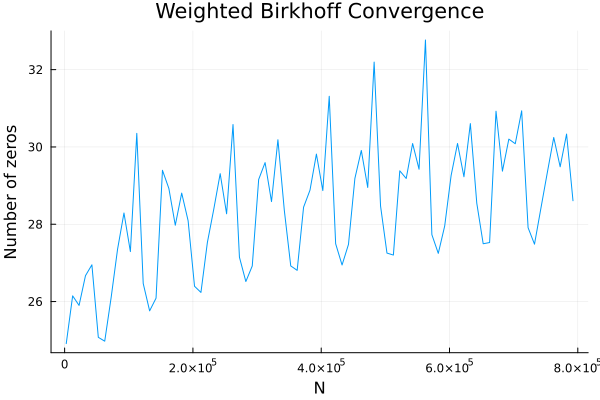

In [328]:
display(Birkhoff_Functions.plot(N_list_big, length_quasi_orbits, title="Weighted" * " Birkhoff Convergence", ylabel="Number of " * "zeros", xlabel="N", legend=false))

## Variables for Plotting

In [333]:
n = 10
delta_plotting = 3

fixed_param_f(x) = continuable_weighted_birkhoff_function(x, n, delta_plotting)

scale_factor = Birkhoff_Functions.initial_area_delta(n, fixed_param_f)

println("Scaling by ", scale_factor)

Scaling by 6.999999999999649


### Plotting Graph of Non-scaled Curve

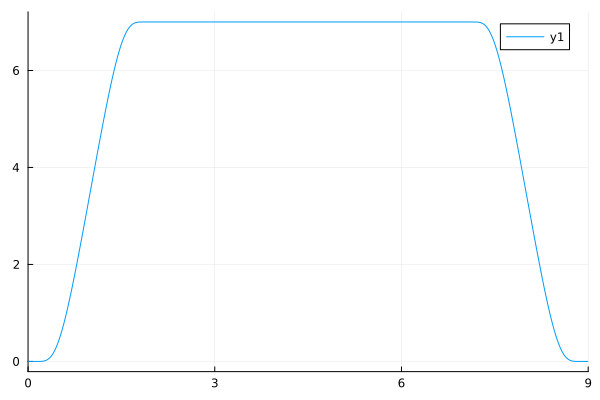

In [334]:
iter = 10000

x_vals = 0:1/iter:n-1

y_vals = Vector{Float64}(undef, length(x_vals))

for i in 1:length(x_vals)
    y_vals[i] = scale_factor*continuable_weighted_birkhoff_function(x_vals[i], n, delta_plotting)
end

Birkhoff_Functions.plot(x_vals, y_vals, xlim=[0,9])

### Plotting Graph of Normalised and Scaled Curve

In [300]:
# function normalised_continuable_weighted_birkhoff_function(x_n, N, delta_plotting)

#     if (delta_plotting-1 <= (N-1)*x_n && (N-1)*x_n < (N-1)-(delta_plotting-1))
#         return 1
#     end

#     function g(x_n) return f(x_n)/(f(x_n)+k(1-x_n)) end
#     function h(x_n) return 1-g(q(x_n)/q(delta_plotting-1)) end

#     if ((N-1)*x_n < delta_plotting-1)
#         return h((N-1)*x_n-(delta_plotting-1))
#     else
#         m = N - 2*delta_plotting + 1
#         return h((N-1)*x_n-(delta_plotting-1+m))
#     end
# end

# x_vals = 0:1/iter:1

# y_vals = Vector{Float64}(undef, length(x_vals))

# for i in 1:length(x_vals)
#     y_vals[i] = scale_factor*normalised_continuable_weighted_birkhoff_function(x_vals[i], n, delta_plotting)
# end

# Birkhoff_Functions.plot(x_vals, y_vals)

## Convergence Results for Different Deltas and Increments of N

In [340]:
# largest_N = 4000
# smallest_delta = 250
# largest_delta = 1450
# delta_step_size = 500
# N_step_size = 400

# delta_list = smallest_delta:delta_step_size:largest_delta

# println("Delta List: ")
# for d in delta_list
#     println(d)
# end

# N_list = smallest_delta*2:N_step_size:largest_N

# println("\nN List: ")
# for n in N_list
#     println(n)
# end

# delta_metrics = Matrix{Vector{Float64}}(undef, length(delta_list), length(N_list))

Delta List: 
250
750
1250

N List: 


500
900
1300
1700
2100
2500
2900
3300
3700


3×9 Matrix{Vector{Float64}}:
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef
 #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef  #undef

In [341]:
# function compute_for_Ns(original_initial_conditions, delta_metrics, delta_list, j)
#     delta = delta_list[j]

#     right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N = base_case(original_initial_conditions, delta)

#     N_list = delta*2:N_step_size:largest_N

#     i = 1
#     for N in N_list
#         trial_N = zeros(2)

#         trial_N[1] = N

#         right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N = evolve_to_N(N, right_delta_evolutions, scatter_dump, WB_left, WB_middle, WB_right, curr_N, delta)

#         original_initial_conditions_2 = [[subvector[end]] for subvector in right_delta_evolutions]

#         right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2 = base_case(original_initial_conditions_2, delta)

#         right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2 = evolve_to_N(N, right_delta_evolutions_2, scatter_dump_2, WB_left_2, WB_middle_2, WB_right_2, curr_N_2, delta)

#         trial_N[2] = length(find_quasi_orbits(WB_left, WB_middle, WB_right, WB_left_2, WB_middle_2, WB_right_2, delta_A_0, N, delta))

#         delta_metrics[j,i] = trial_N

#         i += 1
#     end
# end

# # i = 4
# for i in 1:length(delta_list)
#     compute_for_Ns(original_initial_conditions, delta_metrics, delta_list, i)
# end

In [348]:
using Plots: plot!

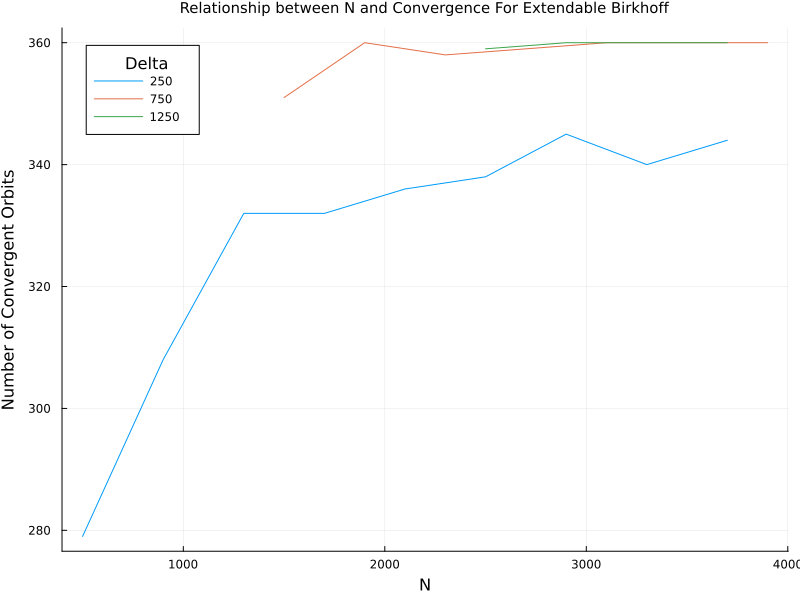

In [349]:
plotting_vec_of_vec = Vector{Vector{Float64}}()

for i in 1:length(delta_list)
    vec_x = Vector{Float64}()
    vec_y = Vector{Float64}()
    for j in 1:length(N_list)
        if isassigned(delta_metrics, i,j) == true
            push!(vec_x, delta_metrics[i,j][1])
            push!(vec_y, delta_metrics[i,j][2])
        end
    end
    push!(plotting_vec_of_vec, vec_x)
    push!(plotting_vec_of_vec, vec_y)
end

list_plots = []

default(size=(800, 600))

main_plot = plot(
    xlabel="N", 
    ylabel="Number of Convergent Orbits", 
    legendtitle="Delta",
    title="Relationship between N and Convergence For Extendable Birkhoff",
    titlefont=font(10)
)

for i in 1:length(delta_list)
    plot!(main_plot, plotting_vec_of_vec[2*i-1], plotting_vec_of_vec[2*i], legend=true, c=:auto, label=delta_list[i])
end

display(main_plot)

In [304]:
# save("Convergence_Extendable_Birkhoff.jld", "data", delta_metrics)
# output = load("Convergence_Extendable_Birkhoff.jld")
# savefig("Convergence_Extendable_Birkhoff.png")

# println(output["data"])